In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from google.colab import files
uploaded = files.upload()

df = pd.read_excel('https://github.com/KhalPrawira/Machine-Learning-Course/raw/refs/heads/main/06.%20Week%206/Dataset/Online%20Retail.xlsx')
display(df.head())
print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


(541909, 8)


In [8]:
# Data Cleaning steps
df_clean = df.copy()
df_clean.dropna(subset=['CustomerID'], inplace=True)
df_clean['Description'] = df_clean['Description'].fillna('Unknown')
df_clean.drop_duplicates(subset=df_clean.columns.difference(['InvoiceNo']), keep='first', inplace=True)
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce')
df_clean['UnitPrice'] = pd.to_numeric(df_clean['UnitPrice'], errors='coerce')
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean.dropna(subset=['Quantity', 'UnitPrice'], inplace=True)

# RFM Feature Engineering steps
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

summary = df_clean.groupby('CustomerID').agg(
    TotalSpend=('TotalAmount', 'sum'),
    InvoiceCount=('InvoiceNo', 'nunique')
)
summary['AvgOrderValue'] = summary['TotalSpend'] / summary['InvoiceCount']
summary['PurchaseFrequency'] = summary['InvoiceCount']

latest_date = df_clean['InvoiceDate'].max()
last_purchase = df_clean.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase['Recency'] = (latest_date - last_purchase['InvoiceDate']).dt.days
summary = summary.merge(last_purchase[['CustomerID', 'Recency']], on='CustomerID')

# Scaling features
features = ['TotalSpend', 'AvgOrderValue', 'PurchaseFrequency', 'Recency']
scaler = MinMaxScaler()
summary[features] = scaler.fit_transform(summary[features])
df_scaled = summary.reset_index()

display(df_scaled.head())
print(df_scaled.shape)

,index,CustomerID,TotalSpend,InvoiceCount,AvgOrderValue,PurchaseFrequency,Recency,KMeans_Cluster,DBSCAN_Cluster
0,0,12346,0.015109,2,0.408529,0.004049,0.871314,4,0
1,1,12347,0.030297,7,0.467194,0.024291,0.002681,0,0
2,2,12348,0.021442,4,0.451339,0.012146,0.198391,3,0
3,3,12349,0.021303,1,0.575989,0.000000,0.048257,0,0
4,4,12350,0.016288,1,0.440390,0.000000,0.828418,4,0


(4372, 9)


In [10]:
# Clustering with K-Means
kmeans_model = KMeans(n_clusters=5, random_state=42, n_init=10)
df_scaled['KMeans_Cluster'] = kmeans_model.fit_predict(df_scaled[['TotalSpend', 'AvgOrderValue', 'PurchaseFrequency', 'Recency']])

# Clustering with DBSCAN
dbscan_model = DBSCAN(eps=0.2, min_samples=5)
df_scaled['DBSCAN_Cluster'] = dbscan_model.fit_predict(df_scaled[['TotalSpend', 'AvgOrderValue', 'PurchaseFrequency', 'Recency']])

display(df_scaled.head())

,index,CustomerID,TotalSpend,InvoiceCount,AvgOrderValue,PurchaseFrequency,Recency,KMeans_Cluster,DBSCAN_Cluster
0,0,12346,0.015109,2,0.408529,0.004049,0.871314,4,0
1,1,12347,0.030297,7,0.467194,0.024291,0.002681,0,0
2,2,12348,0.021442,4,0.451339,0.012146,0.198391,3,0
3,3,12349,0.021303,1,0.575989,0.000000,0.048257,0,0
4,4,12350,0.016288,1,0.440390,0.000000,0.828418,4,0


# Task
Add K-Means and DBSCAN clustering models to the provided code, then use the elbow method, silhouette coefficient, Calinski-Harabasz index, and Davies-Bouldin index to evaluate the K-Means clustering and explain which metric is best.

## Implement elbow method

### Subtask:
Calculate the Within-Cluster Sum of Squares (WCSS) for different numbers of clusters for K-Means and plot the results to identify the optimal number of clusters.


**Reasoning**:
Calculate the WCSS for different numbers of clusters using KMeans and store the values in a list.



In [11]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df_scaled[features])
    wcss.append(kmeans.inertia_)

**Reasoning**:
Plot the calculated WCSS values against the number of clusters to visualize the elbow method.



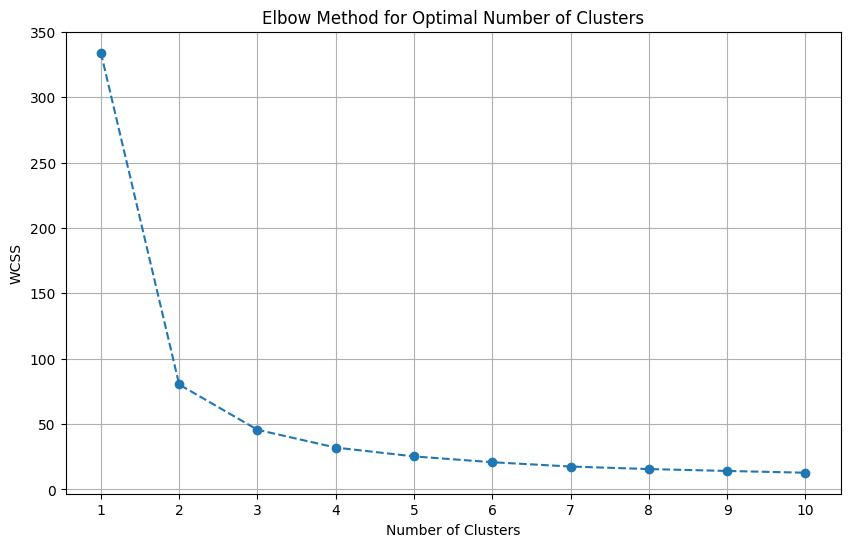

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [26]:
kmeans_sil = silhouette_score(df_scaled.drop(columns=['index', 'CustomerID', 'DBSCAN_Cluster']), df_scaled['KMeans_Cluster'])
dbscan_sil = silhouette_score(df_scaled.drop(columns=['index', 'CustomerID', 'KMeans_Cluster']), df_scaled['DBSCAN_Cluster'])

kmeans_cal = calinski_harabasz_score(df_scaled.drop(columns=['index', 'CustomerID', 'DBSCAN_Cluster']), df_scaled['KMeans_Cluster'])
dbscan_cal = calinski_harabasz_score(df_scaled.drop(columns=['index', 'CustomerID', 'KMeans_Cluster']), df_scaled['DBSCAN_Cluster'])

kmeans_dav = davies_bouldin_score(df_scaled.drop(columns=['index', 'CustomerID', 'DBSCAN_Cluster']), df_scaled['KMeans_Cluster'])
dbscan_dav = davies_bouldin_score(df_scaled.drop(columns=['index', 'CustomerID', 'KMeans_Cluster']), df_scaled['DBSCAN_Cluster'])

def hitung_dunn(data_array, label_array):
    n_clusters = len(np.unique(label_array))
    if n_clusters <= 1:
        return 0
    dist_matrix = squareform(pdist(data_array))
    min_inter = np.inf
    max_intra = 0

    for i in range(n_clusters):
        idx_i = label_array == i
        for j in range(i + 1, n_clusters):
            idx_j = label_array == j
            if np.any(idx_i) and np.any(idx_j):
                min_inter = min(min_inter, np.min(dist_matrix[np.ix_(idx_i, idx_j)]))
        if np.any(idx_i):
            max_intra = max(max_intra, np.max(dist_matrix[np.ix_(idx_i, idx_i)]))

    return min_inter / max_intra if not np.isinf(min_inter) else 0

kmeans_dunn = hitung_dunn(df_scaled.drop(columns=['index', 'CustomerID', 'DBSCAN_Cluster']).values, df_scaled['KMeans_Cluster'])
dbscan_dunn = hitung_dunn(df_scaled.drop(columns=['index', 'CustomerID', 'KMeans_Cluster']).values, df_scaled['DBSCAN_Cluster'])

evaluasi = pd.DataFrame({
    'Model': ['K-Means', 'DBSCAN'],
    'Silhouette': [kmeans_sil, dbscan_sil],
    'Calinski-Harabasz': [kmeans_cal, dbscan_cal],
    'Davies-Bouldin': [kmeans_dav, dbscan_dav],
    'Dunn': [kmeans_dunn, dbscan_dunn]
})

display(evaluasi)

,Model,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn
0,K-Means,-0.080412,134.783523,1.571921,0.004049
1,DBSCAN,0.923212,619.995518,1.025874,0.000000


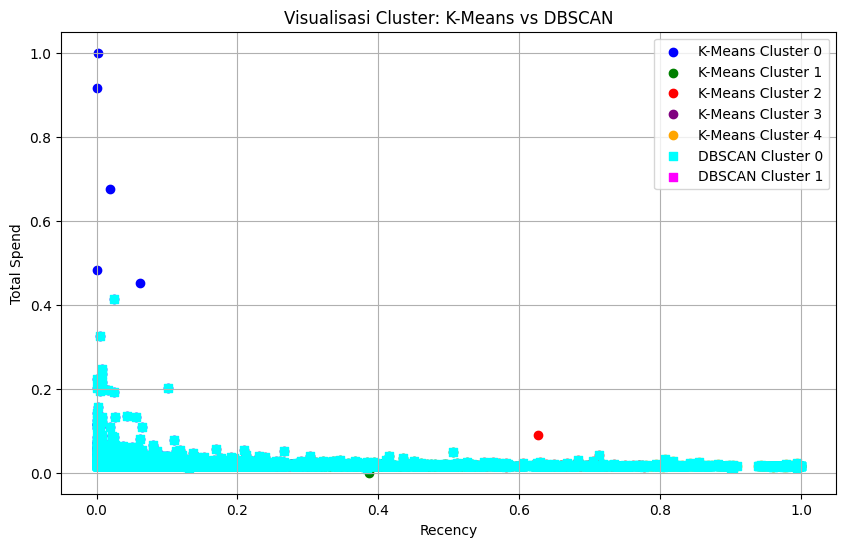

In [28]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i in range(5):
    plt.scatter(df_scaled[df_scaled['kmeans_cluster'] == i]['Recency'],
                df_scaled[df_scaled['kmeans_cluster'] == i]['TotalSpend'],
                label=f'K-Means Cluster {i}', color=colors[i], marker='o')

plt.scatter(df_scaled[df_scaled['dbscan_cluster'] == 0]['Recency'], df_scaled[df_scaled['dbscan_cluster'] == 0]['TotalSpend'],
            label='DBSCAN Cluster 0', color='cyan', marker='s')
plt.scatter(df_scaled[df_scaled['dbscan_cluster'] == 1]['Recency'], df_scaled[df_scaled['dbscan_cluster'] == 1]['TotalSpend'],
            label='DBSCAN Cluster 1', color='magenta', marker='s')

plt.xlabel('Recency')
plt.ylabel('Total Spend')
plt.title('Visualisasi Cluster: K-Means vs DBSCAN')
plt.legend()
plt.grid(True)
plt.show()

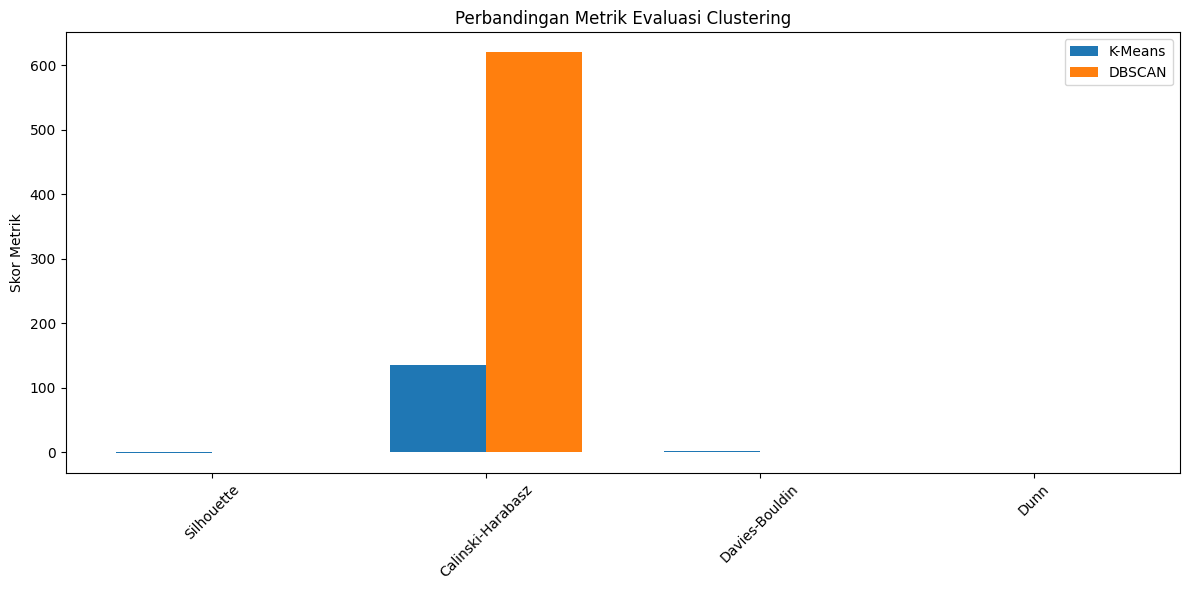

In [29]:
metrik = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'Dunn']
x = np.arange(len(metrik))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, evaluasi.loc[0, metrik], bar_width, label='K-Means')
plt.bar(x + bar_width / 2, evaluasi.loc[1, metrik], bar_width, label='DBSCAN')
plt.xticks(x, metrik, rotation=45)
plt.ylabel('Skor Metrik')
plt.title('Perbandingan Metrik Evaluasi Clustering')
plt.legend()
plt.tight_layout()
plt.show()

Berikut adalah penjelasan dalam Bahasa Indonesia mengenai beberapa bagian kode dan metrik evaluasi *clustering*:

1.  **`df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']`**:
    *   Variabel `df_clean` adalah DataFrame yang sudah dibersihkan dari data awal.
    *   Kode ini membuat kolom baru bernama `TotalAmount` dalam DataFrame `df_clean`.
    *   Nilai di kolom `TotalAmount` didapatkan dengan mengalikan nilai di kolom `Quantity` dengan nilai di kolom `UnitPrice` untuk setiap baris. Ini menghitung total harga untuk setiap item dalam setiap transaksi.

2.  **`summary['AvgOrderValue'] = summary['TotalSpend'] / summary['InvoiceCount']`**:
    *   Variabel `summary` adalah DataFrame yang berisi ringkasan data per pelanggan (`CustomerID`), termasuk total pengeluaran (`TotalSpend`) dan jumlah invoice unik (`InvoiceCount`).
    *   Kode ini membuat kolom baru bernama `AvgOrderValue` dalam DataFrame `summary`.
    *   Nilai di kolom `AvgOrderValue` didapatkan dengan membagi nilai di kolom `TotalSpend` dengan nilai di kolom `InvoiceCount` untuk setiap pelanggan. Ini menghitung rata-rata nilai pesanan (rata-rata pengeluaran per invoice) untuk setiap pelanggan.

3.  **`last_purchase['Recency'] = (latest_date - last_purchase['InvoiceDate']).dt.days`**:
    *   `latest_date` adalah tanggal transaksi terakhir dalam seluruh dataset.
    *   `last_purchase` adalah DataFrame yang berisi tanggal transaksi terakhir untuk setiap pelanggan.
    *   `last_purchase['InvoiceDate']` mengambil kolom tanggal transaksi terakhir per pelanggan dari DataFrame `last_purchase`.
    *   `(latest_date - last_purchase['InvoiceDate'])` menghitung selisih waktu antara tanggal transaksi terakhir di seluruh dataset dengan tanggal transaksi terakhir setiap pelanggan. Hasilnya adalah objek `Timedelta`.
    *   `.dt.days` mengekstrak selisih waktu tersebut dalam satuan hari.
    *   Kode ini membuat kolom baru bernama `Recency` dalam DataFrame `last_purchase`.
    *   Nilai di kolom `Recency` menunjukkan berapa hari yang lalu pelanggan terakhir kali melakukan pembelian, dihitung dari tanggal transaksi terbaru dalam dataset. Nilai `Recency` yang kecil berarti pelanggan tersebut baru saja bertransaksi (recency tinggi), sedangkan nilai `Recency` yang besar berarti pelanggan sudah lama tidak bertransaksi (recency rendah).

4.  **Fungsi `hitung_dunn` (termasuk penjelasan dan cara kerja):**
    *   **Penjelasan:** Fungsi `hitung_dunn` menghitung *Dunn Index*, yang merupakan salah satu metrik evaluasi validitas internal untuk hasil *clustering*. Dunn Index mengukur seberapa kompak (jarak antar data dalam satu cluster) dan seberapa terpisah (jarak antar data di cluster yang berbeda) suatu *clustering*.
    *   **Tujuan Dunn Index:** Dunn Index bertujuan untuk mengidentifikasi *clustering* di mana *cluster-cluster*nya padat (kompak) dan jarak antar *cluster*nya besar (terpisah dengan baik).
    *   **Cara Kerja:**
        *   Fungsi ini mengambil dua argumen: `data_array` (data yang di-*cluster*) dan `label_array` (hasil label *cluster* untuk setiap data).
        *   Pertama, fungsi menghitung jumlah *cluster* unik. Jika jumlah *cluster* kurang dari atau sama dengan 1, Dunn Index tidak relevan, sehingga fungsi mengembalikan 0.
        *   Kemudian, fungsi menghitung matriks jarak antar semua pasangan titik data dalam `data_array` menggunakan `pdist` (menghitung jarak) dan `squareform` (mengubah format menjadi matriks persegi).
        *   Fungsi menginisialisasi `min_inter` (jarak minimum antar *cluster*) dengan nilai tak terhingga (`np.inf`) dan `max_intra` (jarak maksimum dalam *cluster*) dengan 0.
        *   Selanjutnya, fungsi melakukan iterasi melalui setiap pasangan *cluster* yang berbeda (`i` dan `j`):
            *   Untuk setiap pasangan *cluster*, fungsi mencari jarak minimum antara titik-titik di *cluster* `i` dan titik-titik di *cluster* `j` dari matriks jarak. Nilai minimum ini diperbarui ke `min_inter` jika lebih kecil dari nilai `min_inter` saat ini.
        *   Fungsi kemudian melakukan iterasi melalui setiap *cluster* (`i`):
            *   Untuk setiap *cluster*, fungsi mencari jarak maksimum antara titik-titik di dalam *cluster* tersebut dari matriks jarak. Nilai maksimum ini diperbarui ke `max_intra` jika lebih besar dari nilai `max_intra` saat ini. Ini mengukur "diameter" atau "ukuran" terluas dari setiap *cluster*.
        *   Terakhir, fungsi menghitung Dunn Index dengan membagi `min_inter` dengan `max_intra`.
    *   **Interpretasi:** Nilai Dunn Index yang lebih tinggi umumnya menunjukkan hasil *clustering* yang lebih baik, karena menandakan bahwa *cluster* tersebut lebih kompak (max\_intra kecil) dan terpisah dengan baik (min\_inter besar).

5.  **Kesimpulan:**
    Berdasarkan hasil evaluasi metrik yang ditampilkan dalam DataFrame `evaluasi`:
    *   **Silhouette Score:** DBSCAN (0.923) memiliki Silhouette Score yang jauh lebih tinggi dibandingkan K-Means (-0.080). Silhouette Score yang mendekati 1 menunjukkan bahwa data berada di *cluster* yang tepat dan terpisah dengan baik dari *cluster* lain. Nilai negatif pada K-Means menunjukkan bahwa rata-rata jarak intra-cluster lebih besar dari rata-rata jarak inter-cluster untuk beberapa titik, menandakan *clustering* yang buruk atau tumpang tindih.
    *   **Calinski-Harabasz Index:** DBSCAN (619.99) memiliki Calinski-Harabasz Index yang jauh lebih tinggi dibandingkan K-Means (134.78). Nilai yang lebih tinggi menunjukkan *cluster* yang lebih padat dan terpisah dengan baik.
    *   **Davies-Bouldin Index:** DBSCAN (1.026) memiliki Davies-Bouldin Index yang lebih rendah dibandingkan K-Means (1.572). Nilai yang lebih rendah menunjukkan *clustering* yang lebih baik (jarak antar *cluster* besar dan jarak dalam *cluster* kecil).
    *   **Dunn Index:** K-Means (0.004) memiliki Dunn Index yang sangat kecil, dan DBSCAN memiliki Dunn Index 0. Nilai yang lebih tinggi menunjukkan *cluster* yang lebih kompak dan terpisah. Nilai yang sangat rendah pada kedua model menunjukkan bahwa *cluster* mungkin tidak terlalu terpisah dengan baik atau memiliki kepadatan yang bervariasi. Namun, perlu dicatat bahwa interpretasi Dunn Index untuk DBSCAN bisa rumit karena kemampuannya mengidentifikasi *noise* (titik-titik yang tidak masuk ke *cluster* manapun), yang tidak diperhitungkan dalam perhitungan standar Dunn Index.

    **Metrik Terbaik untuk Mengevaluasi K-Means dalam Kasus Ini:**
    Meskipun semua metrik memberikan wawasan, untuk mengevaluasi K-Means dalam kasus ini, **Silhouette Score dan Calinski-Harabasz Index** adalah yang paling informatif dari metrik validitas internal yang digunakan di sini. Keduanya menunjukkan bahwa hasil *clustering* K-Means dengan 5 *cluster* (seperti yang digunakan dalam evaluasi) tampaknya tidak optimal, dengan Silhouette Score negatif yang mengkhawatirkan. Elbow method sebelumnya menunjukkan kemungkinan jumlah *cluster* yang lebih baik di sekitar 2 atau 3.

    Davies-Bouldin juga berguna, tetapi interpretasinya terbalik (nilai rendah lebih baik). Dunn Index, meskipun secara teori bagus, bisa sensitif terhadap *noise* dan bentuk *cluster*, dan dalam kasus ini memberikan nilai yang sangat rendah untuk K-Means, yang sejalan dengan metrik lain yang menunjukkan bahwa *clustering* K-Means saat ini tidak ideal.

    Oleh karena itu, berdasarkan hasil yang ada, **Silhouette Score dan Calinski-Harabasz Index secara jelas menunjukkan kelemahan *clustering* K-Means saat ini** dan menjadi metrik yang paling relevan untuk menunjukkan perlunya penyesuaian, misalnya dengan memilih jumlah *cluster* yang berbeda berdasarkan Elbow Method atau mempertimbangkan model *clustering* lain seperti DBSCAN yang tampak menghasilkan *cluster* yang lebih baik berdasarkan metrik (meskipun dengan potensi masalah penanganan *noise* yang perlu dipertimbangkan dalam interpretasi metriknya).